In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import tqdm


/Users/scottjg2/Sites/STA380/notebooks/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# Download the MNIST dataset and create data loaders
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)



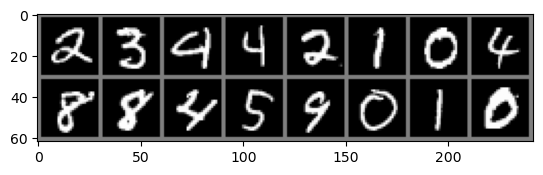

Labels: 2 3 4 4 2 1 0 4 8 8 4 5 9 0 1 0


In [3]:
# Function to display a sample of images
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training images and display them
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:16]))
print('Labels:', ' '.join('%d' % labels[j] for j in range(16)))

In [4]:
# Let's define a simple CNN to classify digits

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)  # in_channels, out_channels, kernel_size, stride
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [5]:
# Set the device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())



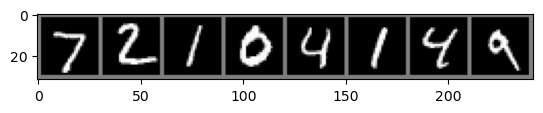

Predicted: 9 9 9 9 9 9 9 9


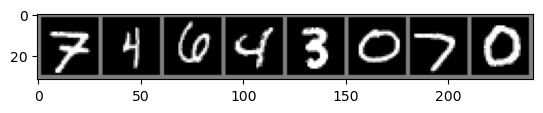

Predicted: 7 4 2 4 3 0 7 0


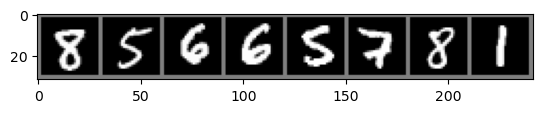

Predicted: 8 5 6 6 5 7 8 1


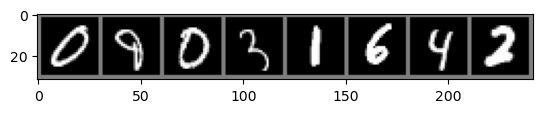

Predicted: 0 3 0 5 1 6 4 2


In [6]:
# Number of training epochs
num_epochs = 5

testiter = iter(testloader)
# Main training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward, and optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 20 == 0:
            with torch.no_grad():
                # Show a sample of images from the test data and model's predictions
                test_images, test_labels = testiter.next()
                test_images, test_labels = test_images.to(device), test_labels.to(device)

                imshow(torchvision.utils.make_grid(test_images[:8].cpu()))
                test_outputs = net(test_images[:8])
                _, predicted = torch.max(test_outputs, 1)
                print('Predicted:', ' '.join('%d' % predicted[j] for j in range(8)))

    # Print average loss for the epoch
    print(f"Epoch {epoch+1}, Loss: {running_loss / (i+1)}")


print('Finished Training')
